# Performance Figure
This notebook collects results from different GCN Multi-Omics trainings as well as HotNet2 and MutSigCV. It then shows the performance of all those methods as a scatterplot.
Each method in this plot represents a point and its coordinates represent the performance of it.
The x-axis depicts the performance on the known cancer genes (training + set set for GCN) and the y-axis depicts the performance on the candidate cancer genes from the NCG.

**Different metrics can be chosen to measure the performance. Currently, precision, recall, AUPR and F1 score can be used.**

Metrics:

* Precision measures the fraction of cancer genes out of all genes that were predicted by the algorithm
* Recall measures the fraction of cancer genes that were found (out of all the cancer genes)
* AUPR measures the area under the precision recall curve, so it incorporates both scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn as sns
import os, sys
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import gcnIO
%matplotlib inline

In [2]:
# get metrics from different multi-omics trainings
dir_multinet = '../data/GCN/training/all_multiomics_multinet/'
dir_cpdb = '../data/GCN/training/all_multiomics_CPDB/'
dir_iref = '../data/GCN/training/2019_07_26_10_04_31/'
dir_cnasnvadded = '../data/GCN/training/all_omics_IREF_cnaseparate/'
dir_degnorm = '../data/GCN/training/all_omics_mymutationsnocna_rownormalized/'

In [3]:
def _get_training_data(training_dir):
    args, data_file = gcnIO.load_hyper_params(training_dir)
    if os.path.isdir(data_file): # FIXME: This is hacky and not guaranteed to work at all!
        network_name = None
        for f in os.listdir(data_file):
            if network_name is None:
                network_name = f.split('_')[0].upper()
            else:
                assert (f.split('_')[0].upper() == network_name)
        fname = '{}_{}.h5'.format(network_name, training_dir.strip('/').split('/')[-1])
        data_file = os.path.join(data_file, fname)
    data = gcnIO.load_hdf_data(data_file)
    return data

def _get_optimal_cutoff(pred, node_names, test_mask, y_test):
    pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
    y_true = pred_test.label
    y_score = pred_test.Mean_Pred
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold

def _get_predictions(train_dir):
    pred_file = os.path.join(train_dir, 'ensemble_predictions.tsv')
    if os.path.isfile(pred_file):
        pred = pd.read_csv(pred_file, sep='\t')
        return pred
    else:
        return None

def _get_metric_score(pred, node_names, knowns, candidates, cutoff, metric='recall'):
    predicted_genes = pred[pred.Mean_Pred >= cutoff]
    y_knowns = pred.Name.isin(knowns)
    y_candidates = pred.Name.isin(candidates)
    if metric.upper() == 'RECALL':
        rec_known = recall_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        rec_cand = recall_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return rec_known, rec_cand
    elif metric.upper() == 'PRECISION':
        prec_known = precision_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        prec_cand = precision_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return prec_known, prec_cand
    elif metric.upper() == 'AUPR':
        aupr_known = average_precision_score(y_score=pred.Mean_Pred, y_true=y_knowns)
        aupr_cand = average_precision_score(y_score=pred.Mean_Pred, y_true=y_candidates)
        return aupr_known, aupr_cand
    elif metric.upper() == 'F1':
        f1_known = f1_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        f1_cand = f1_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return f1_known, f1_cand
    
def get_metrics_for_training(data_dir, metric='recall', digsee_sets=False):
    all_metrics = []
    data_types = []
    for d in os.listdir(data_dir):
        training_dir = os.path.join(data_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            metrics = get_metrics_for_single_training(training_dir, metric=metric, digsee_sets=digsee_sets)
            all_metrics.append(metrics)
            data_types.append(d)
    return all_metrics, data_types

def get_metrics_for_single_training(training_dir, metric='recall', digsee_sets=False):
    if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
        data = _get_training_data(training_dir)
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        pred = _get_predictions(training_dir)
        cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
        
        oncoKB, ncg_cand = get_cancer_genes_for_net(training_dir)
        oncokb_metric, ncg_cand_metric = _get_metric_score(pred, node_names, oncoKB, ncg_cand, cutoff, metric=metric)
        
        if digsee_sets:
            ds_mut, ds_meth, ds_expr = get_all_digsee_sets(training_dir)
            ds_mut_metric, ds_meth_metric = _get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, metric)
            ds_expr_metric, _ = _get_metric_score(pred, node_names, ds_expr, ds_expr, cutoff, metric)
            return ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
        else:
            return ncg_cand_metric, oncokb_metric

def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)

    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv('/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    candidate_cancer_genes_innet = candidate_cancer_genes_innet[~candidate_cancer_genes_innet.isin(oncokb_no_ncg)]
    #oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    return oncokb_innet, candidate_cancer_genes_innet


def _get_digsee_genes(base_dir, nodes, to_be_removed, threshold):
    pan_cancer_genes = []
    for f in os.listdir(base_dir):
        if f.startswith('mutation') or f.startswith('expression') or f.startswith('methylation'):
            ctype = f.split('.')[0].split('_')[1]
            fname = os.path.join(base_dir, f)
            evidence = pd.read_csv(fname, sep='\t')
            high_scores = evidence[evidence['EVIDENCE SENTENCE SCORE'] >= threshold]
            pan_cancer_genes += high_scores['GENE SYMBOL'].tolist()
    pan_cancer_genes_filtered = [i for i in pan_cancer_genes if not i in to_be_removed]
    return nodes[nodes.Name.isin(pan_cancer_genes)].Name


def get_all_digsee_sets(train_dir, threshold=0.3):
    if train_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(train_dir)
    else:
        data = _get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    to_be_removed = nodes[np.logical_or(y_train.reshape(-1), y_val.reshape(-1))].Name
    expr_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/expression/', nodes, to_be_removed, threshold)
    meth_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/methylation/', nodes, to_be_removed, threshold)
    muta_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/mutation/', nodes, to_be_removed, threshold)
    return muta_genes, meth_genes, expr_genes


def get_metric_for_mutsigcv(model_dir, metric='recall', digsee_sets=False):
    # get the basic data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # get the MutSigCV scores
    mutsigcv_scores = pd.read_csv('../data/pancancer/mutsigcv/mutsigcv_genescores.csv',
                                  index_col=0, sep='\t').max(axis=1)
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    mutsigcv_scores_filled = mutsigcv_scores.reindex(nodes.Name).fillna(0)
    mutsigcv_df = pd.DataFrame(mutsigcv_scores_filled, columns=['Mean_Pred'])
    mutsigcv_df['Name'] = mutsigcv_df.index
    mutsigcv_df['label'] = y_test

    # get sets and compute metrics
    oncoKB, ncg_cand = get_cancer_genes_for_net(model_dir)
    cutoff = _get_optimal_cutoff(mutsigcv_df, node_names, test_mask, y_test)
    oncokb_metric, ncg_cand_metric = _get_metric_score(mutsigcv_df, node_names, oncoKB, ncg_cand, cutoff, metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = _get_metric_score(mutsigcv_df, node_names, ds_mut, ds_meth, cutoff, metric)
        ds_expr_metric, _ = _get_metric_score(mutsigcv_df, node_names, ds_expr, ds_expr, cutoff, metric)
        return ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
    else:
        return ncg_cand_metric, oncokb_metric

def get_hotnet2_results():
    hotnet2_results = {}
    with open('../data/pancancer/hotnet2/hotnet2_results/hotnet2_subnetworks.csv', 'r') as f:
        current_network = None
        current_datatype = None
        all_genes_current = []
        counter = 0
        for line in f.readlines():
            if line.split('\t')[0] in ['HINT+HI2012', 'iRefIndex', 'Multinet']:
                if current_network is None or len(all_genes_current) == 0:
                    pass
                else:
                    hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
                current_network = line.split('\t')[0]
                current_datatype = line.split('\t')[1]
                all_genes_current = []
            if current_network is None:
                continue
            genes = [i.strip() for i in line.split('\t')[2:] if not i in ['', '\n']]
            all_genes_current += genes
        hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
    return hotnet2_results

def compute_hotnet2_metrics(metric='recall', digsee_sets=False):
    collected = []
    datatypes = []
    networks = []
    hotnet2_results = get_hotnet2_results()
    for key in hotnet2_results:
        res_df = pd.DataFrame(hotnet2_results[key], columns=['Name'])
        res_df['Mean_Pred'] = 1
        if key.split('_')[0] == 'Multinet':
            data_dir = dir_multinet
            net = 'Multinet'
        elif key.split('_')[0] == 'iRefIndex':
            data_dir = dir_iref
            net = 'IREF'
        else:
            continue
        # load data for the run
        data = _get_training_data(os.path.join(data_dir, 'multiomics'))
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        res_df_hotnet2 = res_df.set_index('Name').reindex(nodes.Name).fillna(0)
        res_df_hotnet2['Name'] = res_df_hotnet2.index
        
        # get some information on the current run
        datatype = 'Hotnet2 ({} Scores)'.format(key.split('_')[1])
        datatypes.append(datatype)
        networks.append(net)

        oncoKB, ncg_cand = get_cancer_genes_for_net(os.path.join(data_dir, 'multiomics'))
        oncokb_metric, ncg_cand_metric = _get_metric_score(res_df_hotnet2, node_names, oncoKB, ncg_cand, 0.5, metric=metric)
        if digsee_sets:
            ds_mut, ds_meth, ds_expr = get_all_digsee_sets(os.path.join(data_dir, 'multiomics'))
            ds_mut_metric, ds_meth_metric = _get_metric_score(res_df_hotnet2, node_names, ds_mut, ds_meth, 0.5, metric)
            ds_expr_metric, _ = _get_metric_score(res_df_hotnet2, node_names, ds_expr, ds_expr, 0.5, metric)
            collected.append([ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric])
        else:
            collected.append([ncg_cand_metric, oncokb_metric])

    cols = ['NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'] if digsee_sets else ['NCG_Cand', 'OncoKB']
    result = pd.DataFrame(collected, index=datatypes, columns=cols)
    result['Method'] = datatypes
    result['Network'] = networks
    result['ind'] = 'HotNet2'
    result.set_index('ind', inplace=True)
    return result

def compute_deepwalk_metrics(embedding_file, input_file, network_name, metric='recall', digsee_sets=False):
    data = gcnIO.load_hdf_data(input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # train SVM on deepWalk embeddings
    deepwalk_embeddings = pd.read_csv(embedding_file,
                                      header=None, skiprows=1, sep=' ')

    deepwalk_embeddings.columns = ['Node_Id'] + deepwalk_embeddings.columns[1:].tolist()
    deepwalk_embeddings.set_index('Node_Id', inplace=True)
    n_df = pd.DataFrame(node_names, columns=['ID', 'Name'])
    embedding_with_names = deepwalk_embeddings.join(n_df)
    X_dw = embedding_with_names.set_index('Name').reindex(n_df.Name).drop('ID', axis=1)
    X_train_dw = X_dw[train_mask.astype(np.bool)]
    X_test_dw = X_dw[test_mask.astype(np.bool)]
    clf_dw = SVC(kernel='rbf', class_weight='balanced', probability=True)
    clf_dw.fit(X_train_dw, y_train[train_mask.astype(np.bool)].reshape(-1))
    pred_deepwalk = clf_dw.predict_proba(X_dw)
    pred_dw_df = pd.DataFrame(pred_deepwalk, columns=['Mean_Pred', 'Pred_neg'], index=X_dw.index).drop('Pred_neg', axis=1)
    pred_dw_df['Name'] = pred_dw_df.index
    pred_dw_df['label'] = y_test
    cutoff = _get_optimal_cutoff(pred_dw_df, node_names, test_mask, y_test)
    
    oncoKB, ncg_cand = get_cancer_genes_for_net(input_file)
    oncokb_metric, ncg_cand_metric = _get_metric_score(pred_dw_df, node_names, oncoKB, ncg_cand, cutoff, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(input_file)
        ds_mut_metric, ds_meth_metric = _get_metric_score(pred_dw_df, node_names, ds_mut, ds_meth, cutoff, metric)
        ds_expr_metric, _ = _get_metric_score(pred_dw_df, node_names, ds_expr, ds_expr, cutoff, metric)
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['DeepWalk']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['DeepWalk']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'DeepWalk + SVM'
    return perf_df

def compute_gat_metrics(gat_result_file, gat_input_file, network_name, metric='recall', digsee_sets=False):
    gat_results = np.load(gat_result_file)
    gat_results = gat_results.reshape(gat_results.shape[1], gat_results.shape[2])
    data = gcnIO.load_hdf_data(gat_input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    pred = pd.DataFrame(node_names, columns=['ID', 'Name'])
    pred['Mean_Pred'] = gat_results[:, 1] # assuming same order
    pred['label'] = y_test
    cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
    
    oncoKB, ncg_cand = get_cancer_genes_for_net(gat_input_file)
    oncokb_metric, ncg_cand_metric = _get_metric_score(pred, node_names, oncoKB, ncg_cand, cutoff, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(gat_input_file)
        ds_mut_metric, ds_meth_metric = _get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, metric)
        ds_expr_metric, _ = _get_metric_score(pred, node_names, ds_expr, ds_expr, cutoff, metric)
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['GAT']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['GAT']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'GAT'
    return perf_df

## Overlap with other datasets

In [4]:
def _get_random_performance(model_dir):
    data
metric_of_choice = 'aupr'
gcn_training_path = '../data/GCN/training/all_multiomics_CPDB/'

# get metrics for GCN
gcn_all = get_metrics_for_training(gcn_training_path,
                                        metric=metric_of_choice, digsee_sets=True)
gcn_df = pd.DataFrame(gcn_all[0], index=gcn_all[1], columns=['NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'])
gcn_df['Method'] = gcn_all[1]
#multiomics_old = get_metrics_for_single_training('../data/GCN/training/all_multiomics_IREF_withCNA/multiomics/', metric=metric_of_choice, digsee_sets=True)
#mo_old_df = pd.DataFrame(multiomics_old, index=['NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'], columns=['GCN (Old)']).T
#mo_old_df['Method'] = 'GCN (Multiomics Old)'
#gcn_df = gcn_df.append(mo_old_df)

# get metrics for GAT
gat_m = compute_gat_metrics('../data/pancancer/gat_results/results_GAT_IREF.npy',
                           '../data/pancancer/multiomics_containers/IREF_multiomics.h5', 'IREF',
                            metric_of_choice, digsee_sets=True)

# get metrics for HotNet2
hn2_m = compute_hotnet2_metrics(metric=metric_of_choice, digsee_sets=True)

# get metrics for DeepWalk + SVM
dw_m = compute_deepwalk_metrics('../data/pancancer/deepWalk_results/IREF_embedding_CPDBparams.embedding',
                                '../data/pancancer/multiomics_containers/IREF_multiomics.h5', 'IREF',
                                metric=metric_of_choice, digsee_sets=True)

# get metrics for MutSigCV
mscv_m = get_metric_for_mutsigcv(os.path.join(gcn_training_path, 'multiomics'),
                                 metric=metric_of_choice, digsee_sets=True)
mscv_df = pd.DataFrame(mscv_m, columns=['MutSigCV'],
                       index=['NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr']).T


digsee_metrics_competitors = pd.concat((gcn_df, gat_m, dw_m, hn2_m, mscv_df))

/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:36: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
# get random metrics
def _get_random_metric(model_dir, dataset, metric='recall'):
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    if metric.upper() == 'AUPR' or metric.upper() == 'PRECISION':
        random_performance = len(dataset) / network.shape[0]
    elif metric.upper() == 'RECALL':
        return 0.5 # assuming that the classifier has probability of 0.5 to predict positive
    elif metric.upper() == 'F1':
        rand_precision = len(dataset) / network.shape[0]
        rand_recall = 0.5
        random_performance = 2 * ( (rand_precision*rand_recall) / (rand_precision + rand_recall) )
    else:
        print ("Metric {} not understood".format(metric))
    return random_performance

ds_sets = get_all_digsee_sets(os.path.join(gcn_training_path, 'multiomics'))
rand_perfs = {}
count = 0
for i in ['DigSEE Mutation\nGenes', 'DigSEE Methylation\nGenes', 'DigSee Expression\nGenes']:
    rand_perfs[i] = (_get_random_metric('../data/GCN/training/all_multiomics_multinet/multiomics/', ds_sets[count], metric=metric_of_choice))
    count += 1
onco, ncg_cand = get_cancer_genes_for_net(os.path.join(gcn_training_path, 'multiomics'))
rand_perfs['NCG Candidate\nCancer Genes'] = _get_random_metric(os.path.join(gcn_training_path, 'multiomics'), ncg_cand, metric=metric_of_choice)
rand_perfs['OncoKB Genes\n(not in NCG)'] = _get_random_metric(os.path.join(gcn_training_path, 'multiomics'), onco, metric=metric_of_choice)

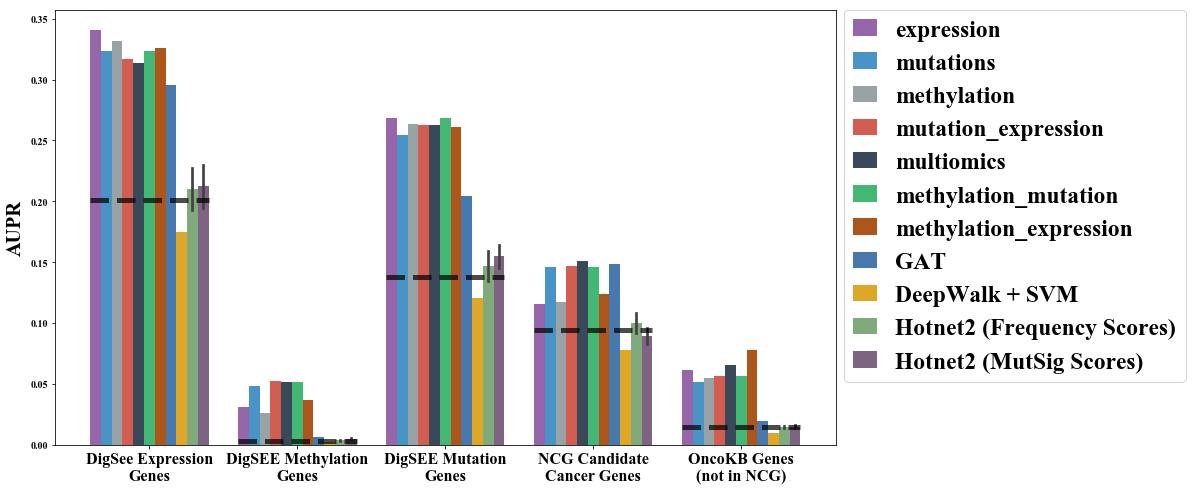

In [6]:
fig = plt.figure(figsize=(14, 8))
digsee_metrics_competitors.columns = ['DigSee Expression\nGenes', 'DigSEE Methylation\nGenes',
                                      'DigSEE Mutation\nGenes', 'Method', 'NCG Candidate\nCancer Genes', 'Network',
                                      'OncoKB Genes\n(not in NCG)']
metrics_melted = digsee_metrics_competitors.drop('Network', axis=1).melt(id_vars='Method')
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange", "windows blue", "amber", "faded green",
                                                       "dusty purple", "light blue",  "black", "light green", "dark blue", "pink", "light yellow"])

p = sns.barplot(data=metrics_melted, x='variable', y='value', hue='Method', palette=colors)

group = 0
for group_name in metrics_melted.variable.unique():
    plt.plot([group-0.4, group+0.4], [rand_perfs[group_name], rand_perfs[group_name]], ls='--', lw=5, alpha=.7, c='black')
    group += 1

#p.axes.axhline(_get_random_metric('../data/GCN/training/all_multiomics_multinet/multiomics/', metric=metric_of_choice), ls='--', lw=6, c='black', alpha=0.4)

plt.ylabel('{}'.format(metric_of_choice.upper()), fontsize=20)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)

In [7]:
x = get_cancer_genes_for_net('../data/GCN/training/TCGA_data_final/multiomics/')
y = get_all_digsee_sets('../data/GCN/training/TCGA_data_final/multiomics/')
len(x[0]), len(x[1]), len(y[0]), len(y[1]), len(y[2])

(191, 1158, 1906, 39, 2758)

In [14]:
training_runs = {'Final': '/project/gcn/diseasegcn/data/GCN/training/2019_07_23_17_26_39/multiomics/',
                 'NCG & DigSEE Labels (New Neg)': '/project/gcn/diseasegcn/data/GCN/training/2019_07_23_14_45_01/',
                 'Old Negatives': '/project/gcn/diseasegcn/data/GCN/training/2019_07_19_12_54_50/',
                 'SNV+CNA Standard':'/project/gcn/diseasegcn/data/GCN/training/all_multiomics_IREF_withCNA/multiomics/',
                 'Mutation Only': '../data/GCN/training/all_multiomics_IREF_withCNA/mutations/',
                 'Old Version': '../data/GCN/training/2018_12_04_16_38_36/'
                }

results = []
names = []
for run in training_runs:
    print (run)
    results.append(get_all_metrics_digsee(training_runs[run], metric=metric_of_choice))
    names.append(run)
    
res_df = pd.DataFrame(results, columns=['NCG Candidates', 'OncoKB Genes', 'DigSEE Mutation', 'DigSEE Methylation', 'DigSEE Expression'])
res_df['Method'] = names

fig = plt.figure(figsize=(14, 8))
#sns.barplot(x=['NCG Candidate Genes', 'OncoKB Genes', 'DigSEE Mutation Genes', 'DigSEE Methylation Genes', 'DigSEE Expression Genes'], y=metrics_for_run)
sns.barplot(data=res_df.melt(id_vars='Method'), x='variable', y='value', hue='Method')
plt.ylabel('{}'.format(metric_of_choice.upper()), fontsize=20)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16)
plt.legend(fontsize=17)
#fig.savefig(os.path.join(training_dir, '{}_independent.svg'.format(metric_of_choice)))
res_df

Final


NameError: name 'get_all_metrics_digsee' is not defined

## Plot metrics for multiple trainings in one figure

In [8]:
metric_of_choice = 'aupr'

training_runs = {'Multinet': dir_multinet, 'CPDB': dir_cpdb,
                 'IREF':dir_iref
                 #'IREF (Old)': dir_cnasnvadded
                 #'IREF (Degree Normalized)': dir_degnorm
                }
all_metrics = []
for network_name in training_runs:
    print (network_name)
    metrics, omics = get_metrics_for_training(training_runs[network_name], metric=metric_of_choice, digsee_sets=False)
    x = pd.DataFrame(metrics, index=omics,
                     columns=['NCG_Cand', 'OncoKB'])
    x['Network'] = network_name
    all_metrics.append(x)
all_metrics_df = pd.concat(all_metrics)
all_metrics_df['Method'] = all_metrics_df.index

"""
metric_known_old, metric_cand_old = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2018_12_04_16_38_36/', metric=metric_of_choice)
add_dict = {'Candidate Cancer Genes': metric_cand_old, 'Known Cancer Genes': metric_known_old, 'Method': 'GCN (Multi-Omics Old)', 'Network': 'IREF'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_known_old, metric_cand_old = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_03_06_15_45_33/', metric=metric_of_choice)
add_dict = {'Candidate Cancer Genes': metric_cand_old, 'Known Cancer Genes': metric_known_old, 'Method': 'GCN (Multi-Omics Old)', 'Network': 'CPDB'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)
"""

# get mutsigcv metrics
print ("Loading MutSigCV performance")
mutsigcv_perf = []
for network_name, network_dir in {'Multinet': dir_multinet, 'CPDB': dir_cpdb, 'IREF':dir_iref}.items():
    ms_perf_known, ms_perf_cand = get_metric_for_mutsigcv(os.path.join(network_dir, 'multiomics'), metric=metric_of_choice)
    mutsigcv_perf.append([ms_perf_known, ms_perf_cand, network_name])
mutsig_perf_df = pd.DataFrame(mutsigcv_perf, columns=['NCG_Cand', 'OncoKB', 'Network'])
mutsig_perf_df['Method'] = 'MutSigCV'
mutsig_perf_df.set_index('Method', inplace=True)
mutsig_perf_df['Method'] = 'MutSigCV'

# compute metrics for HotNet2 results
print ("Computing HotNet2 metrics")
hotnet2_perf = compute_hotnet2_metrics(metric=metric_of_choice)

# compute metrics for deepwalk
print ("Computing DeepWalk metrics")
dw_resdir = '../data/pancancer/deepWalk_results/'
input_basedir = '../data/pancancer/'
dw_paths = {'IREF': ('IREF_embedding_CPDBparams.embedding', 'multiomics_containers/IREF_multiomics.h5'),
             'Multinet': ('MULTINET_embedding_CPDBparams.embedding', 'all_omics_multinet/MULTINET_multiomics.h5'),
             'CPDB': ('CPDB_embedding_CPDBparams.embedding', 'CPDB_multiomics_omimallneg.h5')}
dw_dfs = []
for key in dw_paths:
    res, inp = dw_paths[key]
    dw_dfs.append(compute_deepwalk_metrics(os.path.join(dw_resdir, res),
                                           os.path.join(input_basedir, inp),
                                           network_name=key,
                                           metric=metric_of_choice)
                  )
dw_perf = pd.concat((dw_dfs))

# compute metrics for GAT
print ("Computing GAT metrics")
gat_resdir = '../data/pancancer/gat_results/'
input_basedir = '../data/pancancer/'
gat_paths = {'IREF': ('results_GAT_IREF.npy', 'multiomics_containers/IREF_multiomics.h5'),
             'Multinet': ('results_GAT_MULTINET.npy', 'all_omics_multinet/MULTINET_multiomics.h5'),
             'CPDB': ('results_GAT_attention8_CPDB.npy', 'all_omics_CPDB/CPDB_multiomics.h5')}
gat_dfs = []
for key in gat_paths:
    res, inp = gat_paths[key]
    gat_dfs.append(compute_gat_metrics(os.path.join(gat_resdir, res),
                                       os.path.join(input_basedir, inp),
                                       network_name=key,
                                       metric=metric_of_choice)
                  )
gat_perf = pd.concat((gat_dfs))

all_metrics_df = pd.concat((all_metrics_df, mutsig_perf_df, hotnet2_perf, dw_perf, gat_perf))

Multinet
CPDB
IREF
Loading MutSigCV performance
Computing HotNet2 metrics
Computing DeepWalk metrics


/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Computing GAT metrics


/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:78: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [9]:
"""
metric_known_new, metric_cand_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_18_14_58_23/', metric=metric_of_choice)
add_dict = {'Candidate Cancer Genes': metric_cand_new, 'Known Cancer Genes': metric_known_new, 'Method': 'GCN (Multi-Omics Reprod_old)', 'Network': 'IREF'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_known_new, metric_cand_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_23_12_15_00', metric=metric_of_choice)
add_dict = {'Candidate Cancer Genes': metric_cand_new, 'Known Cancer Genes': metric_known_new, 'Method': 'GCN (Multi-Omics DigSEE + NCG Labels)', 'Network': 'IREF'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_known_new, metric_cand_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_19_13_11_28/', metric=metric_of_choice)
add_dict = {'Candidate Cancer Genes': metric_cand_new, 'Known Cancer Genes': metric_known_new, 'Method': 'GCN (Multi-Omics Reprod_old)', 'Network': 'IREF (SNV+CNA)'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_known_new, metric_cand_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_19_12_54_50/', metric=metric_of_choice)
add_dict = {'Candidate Cancer Genes': metric_cand_new, 'Known Cancer Genes': metric_known_new, 'Method': 'GCN (Multi-Omics Old Negatives)', 'Network': 'IREF'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)
"""
print ()

/home/sasse/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


17 12


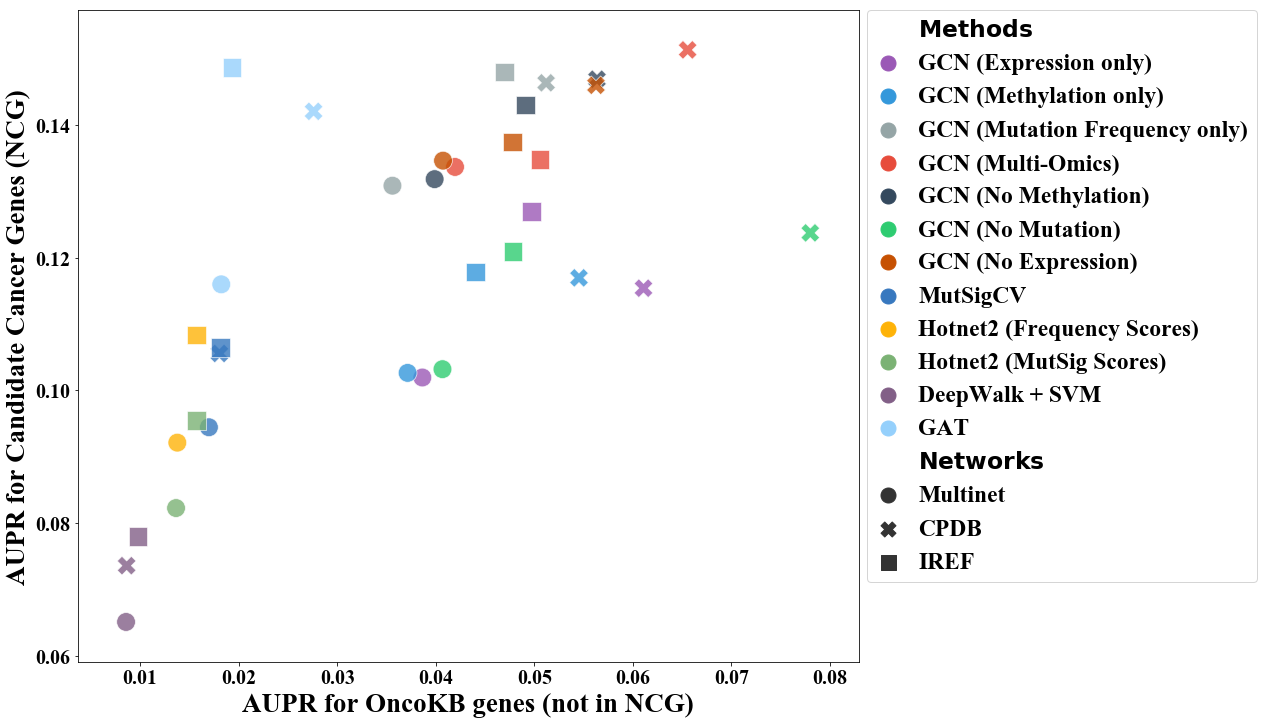

In [10]:
fig = plt.figure(figsize=(14, 12))
replace_dict = {'expression': 'GCN (Expression only)', 'methylation': 'GCN (Methylation only)',
                'mutations': 'GCN (Mutation Frequency only)', 'multiomics': 'GCN (Multi-Omics)',
                'mutation_expression': 'GCN (No Methylation)',
                'methylation_expression': 'GCN (No Mutation)',
                'methylation_mutation': 'GCN (No Expression)',
                'no_cna': 'GCN (No CNA)', 'no_ge': 'GCN (No Expression)',
                'no_meth': 'GCN (No Methylation)', 'no_snvs': 'GCN (No Mutation)'
               }

all_metrics_df_relevant = all_metrics_df[all_metrics_df.index.isin(['multiomics', 'no_snvs', 'no_cna',
                                                                     'expression_mutation', 'mutations',
                                                                     'MutSigCV', 'DeepWalk', 'GAT', 'HotNet2'])]

all_metrics_df.Method = all_metrics_df.Method.replace(replace_dict)
all_metrics_df_relevant.Method = all_metrics_df_relevant.Method.replace(replace_dict)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange", "windows blue", "amber", "faded green",
                                                       "dusty purple", "light blue",  "black", "light green", "dark blue", "pink", "light yellow"])
print (len(colors), all_metrics_df.Method.nunique())

sns.scatterplot(data=all_metrics_df,
                x='OncoKB',
                y='NCG_Cand',
                hue='Method', style='Network',
                alpha=.8, s=350, palette=colors[:all_metrics_df.Method.nunique()])
plt.xlabel('{} for OncoKB genes (not in NCG)'.format(metric_of_choice.upper()), fontsize=27)
plt.ylabel('{} for Candidate Cancer Genes (NCG)'.format(metric_of_choice.upper()), fontsize=27)
plt.tick_params(axis='both', labelsize=20)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)
legend.texts[0].set_text(r"$\bf{Methods}$")
legend.texts[all_metrics_df.Method.nunique()+1].set_text(r"$\bf{Networks}$")
#fig.savefig('../data/pancancer/ensemble_metrics_{}.svg'.format(metric_of_choice), bbox_inches="tight")

In [ ]:

perfect_points_x = []
perfect_points_y = []
onco, cand = get_cancer_genes_for_net('../data/GCN/training/all_multiomics_CPDB/multiomics/')
num_of_tests = len(onco)
for i in range(1, num_of_tests):
    pred = np.concatenate((np.ones(len(cand)), np.ones(i)))
    oncokb = np.concatenate((np.zeros(len(cand)), np.ones(i)))
    cand = np.concatenate((np.ones(len(cand)), np.zeros(i)))
    if metric_of_choice.upper() == 'RECALL':
        score_onco = recall_score(y_pred=pred, y_true=oncokb)
        score_cand = recall_score(y_pred=pred, y_true=cand)
    elif metric_of_choice.upper() == 'PRECISION':
        score_onco = precision_score(y_pred=pred, y_true=oncokb)
        score_cand = precision_score(y_pred=pred, y_true=cand)
    elif metric_of_choice.upper() == 'AUPR':
        score_onco = average_precision_score(y_score=pred, y_true=oncokb)
        score_cand = average_precision_score(y_score=pred, y_true=cand)
    else:
        print ("Metric not recognized")
    perfect_points_x.append(score_onco)
    perfect_points_y.append(score_cand)
    if i % (num_of_tests / 10) == 0:
        print ("Done with {} of {}".format(i, num_of_tests))
fig = plt.figure(figsize=(10, 10))
plt.scatter(perfect_points_x, perfect_points_y)